In [3]:
# in this notebook I will develop a vanilla version of FEA using only basic python functions
# Based on PolymerFEM: https://youtu.be/1j_HdsVkglk
# Description: linear finite element analysis for 2D plane strain for linear elastic materials
# Units: mm

import numpy as np
from matplotlib import pyplot as plt

In [801]:
# defining helper ftions

# converting 'natural' coordinates xi, eta into shape functions: (n1, n2, n3, n4)
def shape(xi,eta):
    N1 = (1 - xi) * (1 - eta)
    N2 = (1 + xi) * (1 - eta)
    N3 = (1 + xi) * (1 + eta)
    N4 = (1 - xi) * (1 + eta)
    Ns = np.array([N1, N2, N3, N4])
    return 0.25 * Ns

# 'natural' coordinates xi, eta into gradients of the shape ftions: [(dn1/dx, dn2/dx, ...),
#                                                                    (dn1/de, dn2/de,...)]
def grad_shape(xi, eta):
    dN = np.array([[-1 * (1-eta), 1 * (1-eta), 1 * (1+eta), -1 * (1+eta)],
                   [-1 * (1-xi), -1 * (1+xi), 1 * (1+xi), 1 * (1-xi)]])
    return 0.25 * dN

# plotting mesh - function call:    plot_mesh(nodes, conn, plot_connections=True)
def plot_mesh(nodes, conn, plot_connections=True, size=10):
    plt.figure(figsize=(size,size))
    plt.grid(color = 'gray', linewidth=0.2)

    if plot_connections:  # plotting connections
        connections = set()
        for el in conn:
            if len(el) == 4:
                c1, c2, c3, c4 = (el[0], el[1]), (el[1], el[2]), (el[2], el[3]), (el[3], el[0])
                connections.add(c1); connections.add(c2); connections.add(c3); connections.add(c4)
            elif len(el) == 3:
                c1, c2, c3 = (el[0], el[1]), (el[1], el[2]), (el[2], el[0])
                connections.add(c1); connections.add(c2); connections.add(c3)
        for (el1, el2) in connections:
            (x1, y1) = nodes[el1]
            (x2, y2) = nodes[el2]
            plt.plot([x1, x2], [y1, y2], linewidth=0.9, color='orange', marker='', zorder=1)

    plt.scatter(nodes[:,0], nodes[:,1], marker='o', color='b', s=5, zorder=2)  # plot nodes
    plt.axis('equal')
    plt.show()

# plotting nodes: numpy array of xs and ys
def plot_nodes(nodes, size=10):
    plt.figure(figsize=(size,size))
    plt.grid(color = 'gray', linewidth=0.2)
    plt.scatter(nodes[:,0], nodes[:,1], marker='o')
    plt.axis('equal')
    plt.title(f"num of nodes {num_nodes}")
    if size >= 8:  # print node labels
        for i,(x,y) in enumerate(nodes):
            plt.text(x, y, str(i))
    plt.show()

In [253]:
# defining a mesh -> list of coordinates for each node
#                 -> list of connections between nodes ('connectivity'/adjacency)

# for a rectancgular block of (num_el_x, num_el_y) elements and dimensions (l_x, l_y)
num_el_x, num_el_y = 9, 49   # num of elements
l_x, l_y = 10, 50            # dimensions in x,y
num_nx = num_el_x + 1        # num of nodes in x
num_ny = num_el_y + 1        # num of nodes in y

num_nodes = num_nx * num_ny
num_elements = num_el_x * num_el_y
hx = l_x / num_el_x
hy = l_y / num_el_y

nodes = []  # list of coordinates of all nodes
for y in np.linspace(0., l_y, num_ny):
    for x in np.linspace(0,l_x, num_nx):
        nodes.append([x,y])
nodes = np.array(nodes)

conn = []  # list of connections for each element
for j in range(num_el_y):
    for i in range(num_el_x):
        n0 = i + j * num_nx
        conn.append([n0, n0 + 1, n0 + 1 + num_nx, n0 + num_nx])


In [254]:
# material specifications
E = 100.1  # Youngs modulus
v = 0.479  # Poisson ratio
c = E / (1 + v) / (1 - 2 * v)      # constant for SM
SM = c * np.array([[1 - v, v, 0],  # Stiffness matrix from Hooks Law for plane strain
                   [v, 1 - v, 0],
                   [0, 0, 0.5 - v]])

In [255]:
# obtaining the global and element stiffness matrix
K = np.zeros((2 * num_nodes, 2 * num_nodes))   # the global stiffness matrix
quad = [[x / np.sqrt(3), y / np.sqrt(3)] for y in [-1,1] for x in [-1,1]] # weights for gaussian quadrature
B = np.zeros((3,8))
for el in conn:
    el_coords = nodes[el,:]  # coordinates of each node
    Ke = np.zeros((8,8))    # init element stiffness matrix
    for q in quad:
        dN = grad_shape(q[0], q[1])
        J  = np.dot(dN, el_coords).T
        dN = np.dot(np.linalg.inv(J), dN)
        B[0, 0::2] = dN[0, :]
        B[1, 1::2] = dN[1, :]
        B[2, 0::2] = dN[1, :]
        B[2, 1::2] = dN[0, :]
        Ke += np.dot(np.dot(B.T,SM),B) * np.linalg.det(J)  # getting element stiffness

    # computing the global stiffness matrix
    for i,I in enumerate(el):
        for j,J in enumerate(el):
            K[2*I, 2*J]     += Ke[2*i, 2*j]
            K[2*I+1, 2*J]   += Ke[2*i+1, 2*j]
            K[2*I+1, 2*J+1] += Ke[2*i+1, 2*j+1]
            K[2*I, 2*J+1]   += Ke[2*i, 2*j+1]

In [269]:
# Boundary conditions and forces
F = np.zeros((2 * num_nodes))
for i in range(num_nodes):
    if nodes[i,1] == 0.0:      # for the bottom layer
        K[2*i,:]   = 0.0
        K[2*i+1,:] = 0.0
        K[2*i,2*i] = 1.0
        K[2*i+1,2*i+1] = 1.0
    if nodes[i,1] == l_y:      # for the top layer
        x = nodes[i,0]
        F[2*i+1] = 10.0
        if x == 0 or x == l_x: # for the sides
            F[2*i+1] *= 0.5

3.3747991423164376


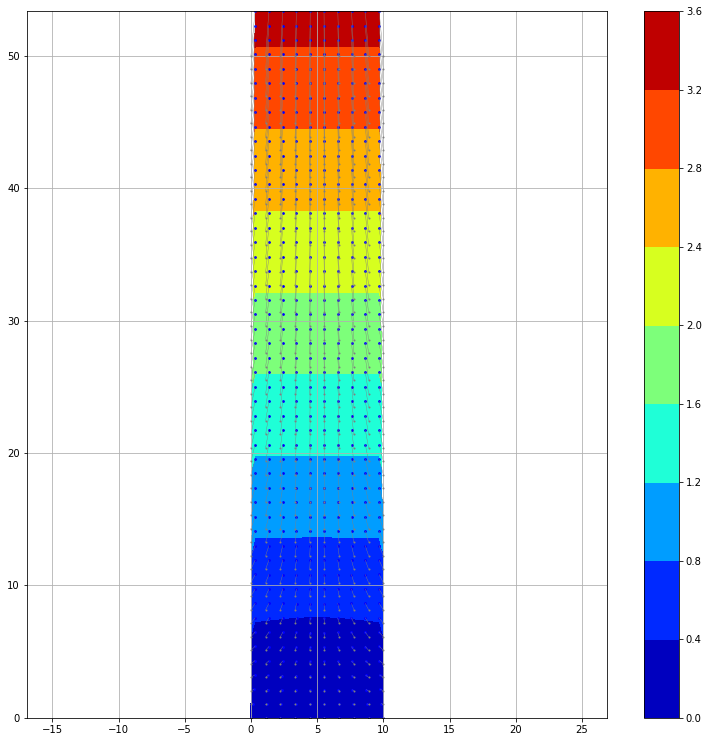

In [270]:
# solving K * Un= R to find displacements of each node
u = np.linalg.solve(K, F)
print(np.max(u))

# plotting the solved displacements
ux = np.reshape(u[0::2], (num_ny, num_nx))  # displacements in X
uy = np.reshape(u[1::2], (num_ny, num_nx))  # displacements in Y
x_new, y_new = [], []
res  = []
for i in range(num_nx):
    for j in range(num_ny):
        x_new.append(i * hx + ux[j,i])
        y_new.append(j * hy + uy[j,i])
        res.append(uy[j,i])
        #res.append(np.sqrt(uy[j,i] ** 2 + ux[j,i] ** 2))
plt.figure(figsize=(13,13))


t = plt.tricontourf(x_new, y_new, res, levels=10, cmap=plt.cm.jet)

plt.scatter(nodes[:,0], nodes[:,1], marker='o', color='gray', s=1, zorder=2)  # plot nodes
for i,n in enumerate(nodes):
    x1, y1 = n[0], n[1]
    x2, y2 = x1 + u[0::2][i], y1 + u[1::2][i]
    #print([y1, y2], '\n')
    plt.plot([x1, x2], [y1, y2], linewidth=0.4, color='gray', marker='', zorder=1)

plt.scatter(x_new, y_new, marker='o', c='b', s=3)
plt.grid()
plt.colorbar(t)
plt.axis('equal')
plt.show()

4.2297986158159295


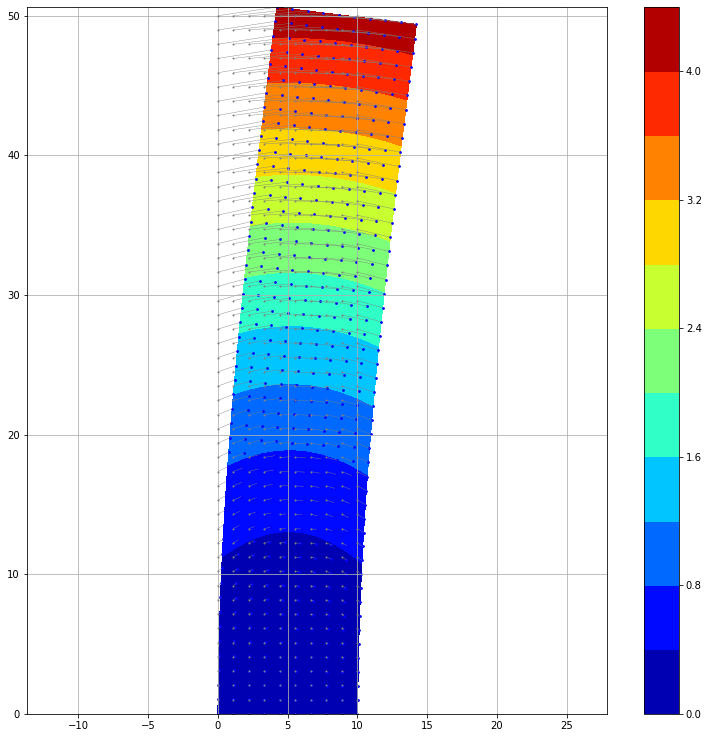

In [493]:
# Example 2: Laterally Loaded block

# material specifications
E = 1000.0  # Youngs modulus
v = 0.400  # Poisson ratio
c = E / (1 + v) / (1 - 2 * v)      # constant for SM
SM = c * np.array([[1 - v, v, 0],  # Stiffness matrix from Hooks Law for plane strain
                   [v, 1 - v, 0],
                   [0, 0, 0.5 - v]])

# defining a mesh
# for a rectangular block of (num_el_x, num_el_y) elements and dimensions (l_x, l_y)
num_el_x, num_el_y = 9, 49   # num of elements
l_x, l_y = 10, 50            # dimensions in x,y
num_nx = num_el_x + 1        # num of nodes in x
num_ny = num_el_y + 1        # num of nodes in y

num_nodes = num_nx * num_ny
num_elements = num_el_x * num_el_y
hx = l_x / num_el_x
hy = l_y / num_el_y

nodes = []  # list of coordinates of all nodes
for y in np.linspace(0., l_y, num_ny):
    for x in np.linspace(0,l_x, num_nx):
        nodes.append([x,y])
nodes = np.array(nodes)

conn = []  # list of connections for each element
for j in range(num_el_y):
    for i in range(num_el_x):
        n0 = i + j * num_nx
        conn.append([n0, n0 + 1, n0 + 1 + num_nx, n0 + num_nx])

# obtaining the global and element stiffness matrix
K = np.zeros((2 * num_nodes, 2 * num_nodes))   # the global stiffness matrix
quad = [[x / np.sqrt(3), y / np.sqrt(3)] for y in [-1,1] for x in [-1,1]] # weights for gaussian quadrature
B = np.zeros((3,8))
for el in conn:
    el_coords = nodes[el,:]  # coordinates of each node
    Ke = np.zeros((8,8))    # init element stiffness matrix
    for q in quad:
        dN = grad_shape(q[0], q[1])
        J  = np.dot(dN, el_coords).T
        dN = np.dot(np.linalg.inv(J), dN)
        B[0, 0::2] = dN[0, :]
        B[1, 1::2] = dN[1, :]
        B[2, 0::2] = dN[1, :]
        B[2, 1::2] = dN[0, :]
        Ke += np.dot(np.dot(B.T,SM),B) * np.linalg.det(J)  # getting element stiffness

    # computing the global stiffness matrix
    for i,I in enumerate(el):
        for j,J in enumerate(el):
            K[2*I, 2*J]     += Ke[2*i, 2*j]
            K[2*I+1, 2*J]   += Ke[2*i+1, 2*j]
            K[2*I+1, 2*J+1] += Ke[2*i+1, 2*j+1]
            K[2*I, 2*J+1]   += Ke[2*i, 2*j+1]

# Boundary conditions and forces
F = np.zeros((2 * num_nodes))
for i in range(num_nodes):
    if nodes[i,1] == 0.0:      # for the bottom layer
        K[2*i,:]   = 0.0
        K[2*i+1,:] = 0.0
        K[2*i,2*i] = 1.0
        K[2*i+1,2*i+1] = 1.0
    if nodes[i,1] == l_y:      # for the top layer: lateral force to the right
        x = nodes[i,0]
        F[2*i] = 1
        if x == 0 or x == l_x: # for the sides
            F[2*i+1] *= 0.5

# solving K * Un= R to find displacements of each node
u = np.linalg.solve(K, F)
print(np.max(u))

# plotting the solved displacements
ux = u[0::2]  # displacements in X
uy = u[1::2]  # displacements in Y
um = np.sqrt(ux ** 2 + uy ** 2)# displacement magnitude
x_new = nodes[:,0] + ux
y_new = nodes[:,1] + uy

# ux = np.reshape(u[0::2], (num_ny, num_nx))  # displacements in X
# uy = np.reshape(u[1::2], (num_ny, num_nx))  # displacements in Y
# x_new, y_new = [], []
# res  = []
# for i in range(num_nx):
#     for j in range(num_ny):
#         x_new.append(i * hx + ux[j,i])
#         y_new.append(j * hy + uy[j,i])
#         res.append(np.sqrt(uy[j,i] ** 2 + ux[j,i] ** 2))



# plotting
plt.figure(figsize=(13,13))
tri_low  = np.array(conn)[:,0:3]      # triangulation connectivity: lower triangles
tri_high = np.array(conn)[:,[0,2,3]]  # triangulation connectivity: higher triangles
tri = np.vstack((tri_low, tri_high))  # triangulated connections
t = plt.tricontourf(x_new, y_new, tri, um, levels=10, cmap=plt.cm.jet)

plt.scatter(nodes[:,0], nodes[:,1], marker='o', color='gray', s=1, zorder=2)  # plot nodes
for i,n in enumerate(nodes):
    x1, y1 = n[0], n[1]
    x2, y2 = x1 + u[0::2][i], y1 + u[1::2][i]
    plt.plot([x1, x2], [y1, y2], linewidth=0.4, color='gray', marker='', zorder=1)

plt.scatter(x_new, y_new, marker='o', c='b', s=3)
plt.grid()
plt.colorbar(t)
plt.axis('equal')
plt.show()

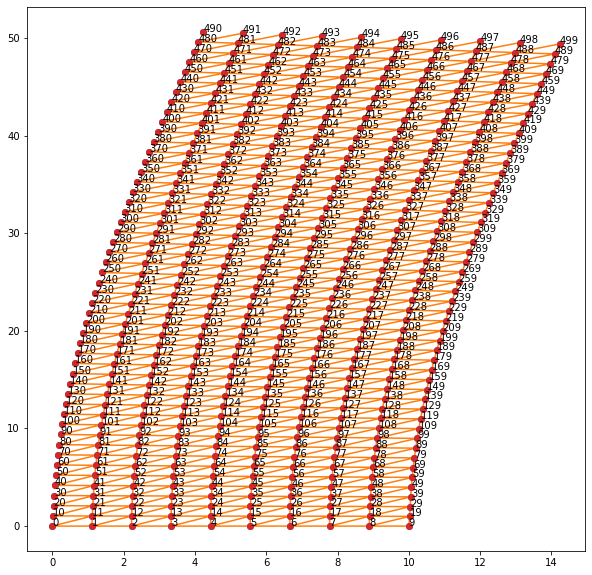

In [494]:
# working with triangulation (Delaunay + 'manual' triangulation)
from scipy.spatial import Delaunay


nodes_new = np.vstack((np.array(x_new), np.array(y_new))).T
# Perform Delaunay triangulation
tri = Delaunay(nodes_new, furthest_site=False, qhull_options='Q')
conn0 = np.array(conn)[:,0:3]
conn1 = np.array(conn)[:,[0,2,3]]
conn3 = np.vstack((conn0, conn1))

plt.figure(figsize=(10,10))
plt.plot(nodes_new[:,0], nodes_new[:,1], 'o')
for i,(x,y) in enumerate(tri.points):
    #print(i, x, y)
    plt.text(x, y, str(i))

# Visualize the triangulation
plt.triplot(nodes_new[:,0], nodes_new[:,1], conn0.copy())
plt.plot(nodes_new[:,0], nodes_new[:,1], 'o')
plt.show()



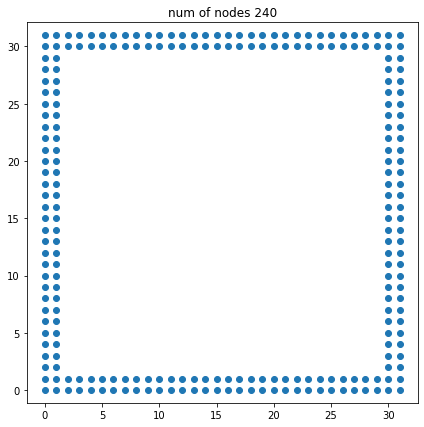

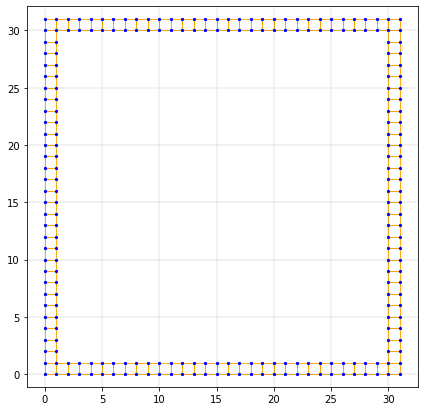

In [798]:
# applying this FEA to more complicated topology - SIMPLE SQUARE OUTLINE

# material specifications
E = 2000.0  # Youngs modulus
v = 0.480   # Poisson ratio
c = E / (1 + v) / (1 - 2 * v)      # constant for SM
SM = c * np.array([[1 - v, v, 0],  # Stiffness matrix from Hooks Law for plane strain
                   [v, 1 - v, 0],
                   [0, 0, 0.5 - v]])

# defining a mesh: square outline
width, height = 30, 30      # dimensions of the square
num_el_x, num_el_y = 30, 30  # num of elements  (minimum is 4)

dx, dy = width / num_el_x, height / num_el_y
num_nodes = (width + height) * 4
nodes = []  # list of coordinates of all nodes: left, top, right, bottom
x, y = 0, 0 # iteration coordinates
while y <= height + dy: # LEFT side
    nodes.append([0 , y])
    nodes.append([dx, y])
    y += dy
x =  dx
y -= dy
while x <= width:       # TOP side
    x += dx
    nodes.append([x, y])
    nodes.append([x, y - dy])
y -= dy
while y >= dy:          # RIGHT side
    y -= dy
    nodes.append([x, y])
    nodes.append([x - dx, y])
x -= dx
while x > 2 * dx:       # BOTTOM side
    x -= dx
    nodes.append([x, 0])
    nodes.append([x, dy])
y = y - dy
nodes = np.array(nodes)

conn = []  # list of connections for each element
x, y = 0, 0 # iteration coordinates (lower left corner of each element)

for i in np.arange(0, 2 * num_el_y + 2, 2):
    conn.append([i , i + 1, i + 3, i + 2])  # LEFT side
#i = 2 * num_el_y + 1
conn.append([i + 1, i+5, i+4, i+3])
for i in np.arange(2 * num_el_y + 5, 2 * (num_el_y + num_el_x) + 3, 2):
    conn.append([i , i + 2, i + 1, i - 1])  # TOP side
conn.append([i + 4, i+3, i+2, i])
for i in np.arange(2 * (num_el_y + num_el_x) + 7, 2 * (num_el_y + num_el_x) + 2 * num_el_y + 5, 2):
    conn.append([i , i - 1, i - 3, i - 2])
conn.append([i+1 , i , i - 2, i + 2])
for i in np.arange(2 * (num_el_y + num_el_x) + 2 * num_el_y + 6, 4 * (num_el_y + num_el_x), 2):
    conn.append([i , i - 2, i - 1, i + 1])
conn.append([1, i , i + 1, 3])

plot_nodes(nodes=nodes, size=7)            # visual check of the mesh - nodes
plot_mesh(nodes=nodes, conn=conn, size=7)  # visual check of the mesh - nodes + connectivity

In [799]:
# obtaining the global and element stiffness matrix
K = np.zeros((2 * num_nodes, 2 * num_nodes))   # the global stiffness matrix
quad = [[x / np.sqrt(3), y / np.sqrt(3)] for y in [-1,1] for x in [-1,1]] # weights for gaussian quadrature
B = np.zeros((3,8))
for el in conn:
    el_coords = nodes[el,:]  # coordinates of each node
    Ke = np.zeros((8,8))    # init element stiffness matrix
    for q in quad:
        dN = grad_shape(q[0], q[1])
        J  = np.dot(dN, el_coords).T
        dN = np.dot(np.linalg.inv(J), dN)
        B[0, 0::2] = dN[0, :]
        B[1, 1::2] = dN[1, :]
        B[2, 0::2] = dN[1, :]
        B[2, 1::2] = dN[0, :]
        Ke += np.dot(np.dot(B.T,SM),B) * np.linalg.det(J)  # getting element stiffness

    # computing the global stiffness matrix
    for i,I in enumerate(el):
        for j,J in enumerate(el):
            K[2*I  , 2*J]     += Ke[2*i, 2*j]
            K[2*I+1, 2*J]   += Ke[2*i+1, 2*j]
            K[2*I+1, 2*J+1] += Ke[2*i+1, 2*j+1]
            K[2*I  , 2*J+1]   += Ke[2*i, 2*j+1]

1.4889917880717716


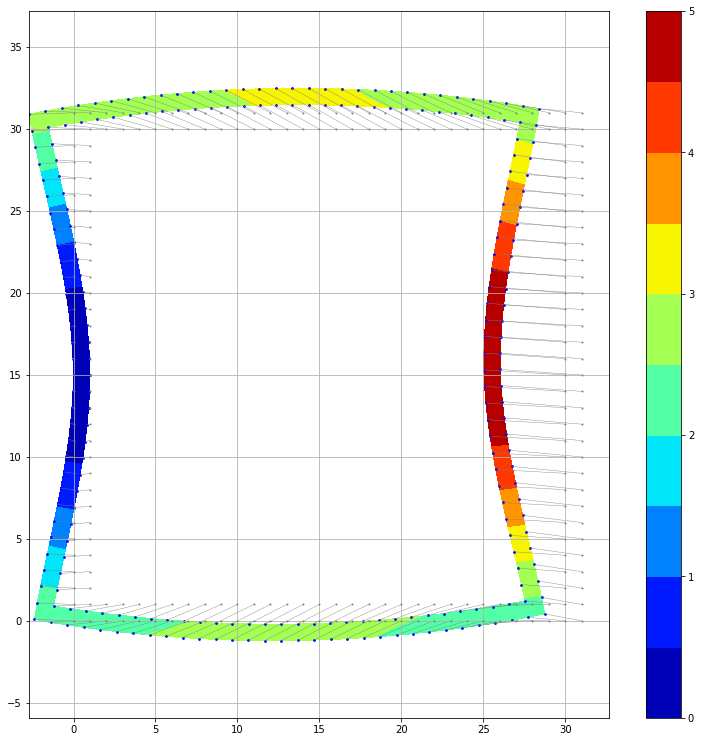

In [800]:
# Boundary conditions and forces: compression force both sides  ->[]<-

F = np.zeros((2 * num_nodes))
for i in range(num_nodes):
    x, y = nodes[i,0], nodes[i,1]

    if x < width // 2:
        if height / 2 <= y < height / 2 + dy:  # middle left: fixed
            K[2*i  , :] = 0.0
            K[2*i+1, :] = 0.0
            K[2*i  , 2*i]   = 1.0
            K[2*i+1, 2*i+1] = 1.0


    if height / 2 <= y < height / 2 + dy:
        if x > width // 2:
            F[2*i] = -5


# Boundary conditions and forces: compression force from the top

    # if nodes[i, 1] == 0.0 or nodes[i,1] == dy:  # bottom layer: fixed
    #     K[2*i  , :] = 0.0
    #     K[2*i+1, :] = 0.0
    #     K[2*i  , 2*i]   = 1.0
    #     K[2*i+1, 2*i+1] = 1.0
    #
    # y = nodes[i,1]
    # if y >= height + dy:
    #     F[2*i + 1] = -1

# solving K * Un= R to find displacements of each node
u = np.linalg.solve(K, F)
print(np.max(u))

# plotting the solved displacements
ux = u[0::2]  # displacements in X
uy = u[1::2]  # displacements in Y
um = np.sqrt(ux ** 2 + uy ** 2) # displacement magnitude
x_new = nodes[:,0] + ux
y_new = nodes[:,1] + uy

# plotting
plt.figure(figsize=(13,13))
tri_low  = np.array(conn)[:,0:3]      # triangulation connectivity: lower triangles
tri_high = np.array(conn)[:,[0,2,3]]  # triangulation connectivity: higher triangles
tri = np.vstack((tri_low, tri_high))  # triangulated connections
t = plt.tricontourf(x_new, y_new, tri, um, levels=10, cmap=plt.cm.jet)

plt.scatter(nodes[:,0], nodes[:,1], marker='o', color='gray', s=1, zorder=2)  # plot nodes
for i,n in enumerate(nodes):
    x1, y1 = n[0], n[1]
    x2, y2 = x1 + u[0::2][i], y1 + u[1::2][i]
    plt.plot([x1, x2], [y1, y2], linewidth=0.4, color='gray', marker='', zorder=1)

plt.scatter(x_new, y_new, marker='o', c='b', s=3)
plt.grid()
plt.colorbar(t)
plt.axis('equal')
plt.show()